<a href="https://colab.research.google.com/github/Henil21/Intro_to_computer_vision_and_CNN/blob/main/Transfer_learning_Part_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

There are two main benefits to using transfer learning:

1. Can leverage an existing neural network architecture proven to work on problems similar to our own.


2. Can leverage a working neural network architecture which has already learned patterns on similar data to our own. This often results in achieving great results with less custom data.

In [ ]:
# lets check we are using gpu or not
!nvidia-smi

Thu Dec  1 04:13:48 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P0    29W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# get data (10$ if 10 food class)
import zipfile
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
zip_ref=zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

--2022-12-01 04:13:48--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.194.128, 142.251.10.128, 142.251.12.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.194.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  20.0MB/s    in 9.0s    

2022-12-01 04:13:58 (17.8 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
import os
for dirpath,dirname,filenames in os.walk("10_food_classes_10_percent"):
  print(f"there are {len(dirname)} directories and {len(filenames)} images in '{dirpath}'")

there are 2 directories and 0 images in '10_food_classes_10_percent'
there are 10 directories and 0 images in '10_food_classes_10_percent/train'
there are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'
there are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'
there are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'
there are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'
there are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'
there are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'
there are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'
there are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'
there are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'
there are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_ric

## Creating loader()
we will use `ImageDataGenerator` class to load in our images in batches

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE=(224,224)
BATCH_SIZE=32
train_dir="10_food_classes_10_percent/train/"
test_dir="10_food_classes_10_percent/test/"

train_datagen=ImageDataGenerator(rescale=1/255)
test_datagen=ImageDataGenerator(rescale=1/255)


train_data=train_datagen.flow_from_directory(train_dir,
                                 target_size=IMAGE_SHAPE,
                                 batch_size=BATCH_SIZE,
                                 class_mode="categorical")

print("testing images:")
test_data=test_datagen.flow_from_directory(test_dir,
                                           target_size=IMAGE_SHAPE,
                                           batch_size=BATCH_SIZE,
                                           class_mode='categorical')

Found 750 images belonging to 10 classes.
testing images:
Found 2500 images belonging to 10 classes.


## Setting Up callback 🔙(things to run while our model trains)

callback are extra functionality we can add to our models to performed during or after training .some of the most popular callbacks:

* Experiment tracking with TensorBoard - log the performance of multiple models and then view and compare these models in a visual way on TensorBoard (a dashboard for inspecting neural network parameters). Helpful to compare the results of different models on your data.


* Model checkpointing - save your model as it trains so you can stop training if needed and come back to continue off where you left. Helpful if training takes a long time and can't be done in one sitting.


* Early stopping - leave your model training for an arbitrary amount of time and have it stop training automatically when it ceases to improve. Helpful when you've got a large dataset and don't know how long training will take.

In [ ]:
# create TensorBoard callback (functionized because we need to create a new model)
import datetime
import tensorflow as tf
def create_tensorboard_callback(dir_name,experiment_name):
  log_dir=dir_name+'/'+experiment_name+"/"+datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback=tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f"saving tfboard log file to{log_dir}")
  return  tensorboard_callback

## Create models using TesnsorFlow Hub⚜

In [ ]:
# Resnet 50 V2 feature vector
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

# Original: EfficientNetB0 feature vector (version 1)
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

# # New: EfficientNetB0 feature vector (version 2)
# efficientnet_url = "https://tfhub.dev/google/imagenet/efficien

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers
# lets make a creat_model() function to create a model from a URL
def create_model(model_url, num_classes=10):
  """Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.
  
  Args:
    model_url (str): A TensorFlow Hub feature extraction URL.
    num_classes (int): Number of output neurons in output layer,
      should be equal to number of target classes, default 10.

  Returns:
    An uncompiled Keras Sequential model with model_url as feature
    extractor layer and Dense output layer with num_classes outputs.
  """
  # Download the pretrained model and save it as a Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False, # freeze the underlying patterns
                                           name='feature_extraction_layer',
                                           input_shape=IMAGE_SHAPE+(3,)) # define the input image shape
  
  # Create our own model
  model = tf.keras.Sequential([
    feature_extractor_layer, # use the feature extraction layer as the base
    layers.Dense(num_classes, activation='softmax', name='output_layer') # create our own output layer      
  ])
  print(num_classes)

  return model
  

> creating and testing ResNet tensorflow Hub feature extraction


In [ ]:
resnet_model=create_model(resnet_url,
                          num_classes=train_data.num_classes)

10


In [ ]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [ ]:
resnet_model.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

In [ ]:
resnet_history=resnet_model.fit(train_data,
                                epochs=5,
                                steps_per_epoch=len(train_data),
                                validation_data=test_data,
                                validation_steps=len(test_data),
                                callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                       experiment_name="resnet50v2")]
                                
                 )

saving tfboard log file totensorflow_hub/resnet50v2/20221201-041416
Epoch 1/5
24/24 [==============================] - 29s 802ms/step - loss: 1.8424 - accuracy: 0.3747 - val_loss: 1.2164 - val_accuracy: 0.6296
Epoch 2/5
24/24 [==============================] - 16s 704ms/step - loss: 0.9337 - accuracy: 0.7147 - val_loss: 0.8772 - val_accuracy: 0.7240
Epoch 3/5
24/24 [==============================] - 17s 735ms/step - loss: 0.6358 - accuracy: 0.8187 - val_loss: 0.7600 - val_accuracy: 0.7540
Epoch 4/5
24/24 [==============================] - 17s 730ms/step - loss: 0.4771 - accuracy: 0.8813 - val_loss: 0.6924 - val_accuracy: 0.7788
Epoch 5/5
24/24 [==============================] - 16s 708ms/step - loss: 0.3835 - accuracy: 0.9107 - val_loss: 0.6697 - val_accuracy: 0.7848


>Great!!

In [ ]:
import matplotlib.pyplot as plt
 
def plot_loss_curve(history):
   loss=history.history['loss']
   val_loss=history.history['val_loss']

   
   accuracy=history.history['accuracy']
   val_accuracy=history.history['val_accuracy']

   epochs=range(len(history.history['loss']))

   plt.plot(epochs,loss,label="training loss")
   plt.plot(epochs,val_loss,label="val_loss")
   plt.title("loss")
   plt.xlabel("epochs")
   plt.legend()
   
   plt.figure()
   plt.plot(epochs,accuracy,label="training_accuracy")
   plt.plot(epochs,val_accuracy,label="val_accuracu")
   plt.title("accuracy")
   plt.xlabel("epochs")
   plt.legend()

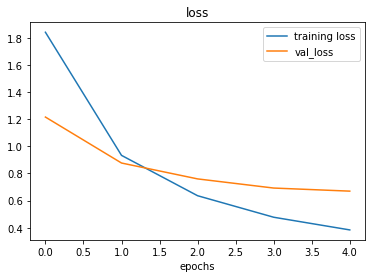

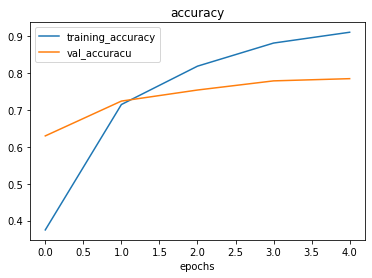

In [ ]:
plot_loss_curve(resnet_history)

## Creating and testing EfficientNetB0 Tesnsorflow Hub features Extraction model

In [ ]:
# create 
effnet_model=create_model(model_url=efficientnet_url)
effnet_model.compile(loss="categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

# fitting
effnet_history=effnet_model.fit(train_data,
                                epochs=5, 
                                steps_per_epoch=len(train_data),
                                validation_data=test_data,
                                validation_steps=len(test_data),
                                callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                       experiment_name="efficientnetb0")])

10
saving tfboard log file totensorflow_hub/efficientnetb0/20221201-041609
Epoch 1/5
24/24 [==============================] - 26s 741ms/step - loss: 1.8334 - accuracy: 0.4400 - val_loss: 1.3086 - val_accuracy: 0.7280
Epoch 2/5
24/24 [==============================] - 16s 675ms/step - loss: 1.0540 - accuracy: 0.7813 - val_loss: 0.8685 - val_accuracy: 0.8160
Epoch 3/5
24/24 [==============================] - 16s 674ms/step - loss: 0.7470 - accuracy: 0.8453 - val_loss: 0.6995 - val_accuracy: 0.8396
Epoch 4/5
24/24 [==============================] - 16s 666ms/step - loss: 0.6021 - accuracy: 0.8680 - val_loss: 0.6134 - val_accuracy: 0.8512
Epoch 5/5
24/24 [==============================] - 15s 661ms/step - loss: 0.5083 - accuracy: 0.8867 - val_loss: 0.5601 - val_accuracy: 0.8580


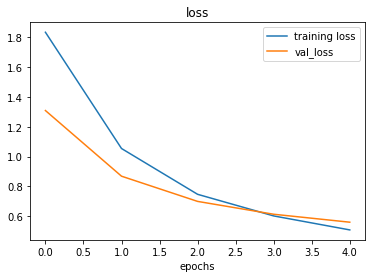

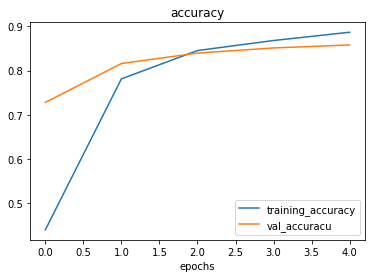

In [ ]:
plot_loss_curve(effnet_history)

In [16]:
effnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1280)             4049564   
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________
